In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt
from skimage.transform import rescale

from sladsnet.input_params import ERDInputParams, GeneralInputParams, SampleParams
from sladsnet.code.measurement_interface import TransmissionSimulationMeasurementInterface, ExperimentMeasurementInterface
from sladsnet.code.erd import SladsSklearnModel
from sladsnet.code.results import Result
from sladsnet.code.base import ExperimentalSample, Sample
from sladsnet.code.sampling import run_sampling
from sladsnet.code.utils import renormalize

In [3]:
from skimage.metrics import structural_similarity, mean_squared_error

In [4]:
cm = mpl.cm.viridis.copy()
#cm.set_bad('black')
cnorm = mpl.colors.LogNorm

In [5]:
def clean_and_normalize(x):
    x = np.nan_to_num(x, nan=0, posinf=0, neginf=0)
    x = (x - x.min()) / (x.max() - x.min())
    return x
    

In [6]:
C_VALUE = 2
train_base_path = Path.cwd().parent.parent / 'ResultsAndData/TrainingData/cameraman/'
erd_model = SladsSklearnModel(load_path=train_base_path / f'c_{C_VALUE}/erd_model_relu.pkl')

In [7]:
exp_data = np.load('coarsescan2.npy')

In [9]:
exp_data.shape

(56, 51, 100)

In [11]:
int1 = np.swapaxes(exp_data.reshape(7,4,2,51,100)[:,:,::-1].reshape(56,51,100)[:,::-1,::-1].reshape(7,8,51,100),1,2).reshape(357,800)

In [14]:
normalized_int = renormalize(int1)

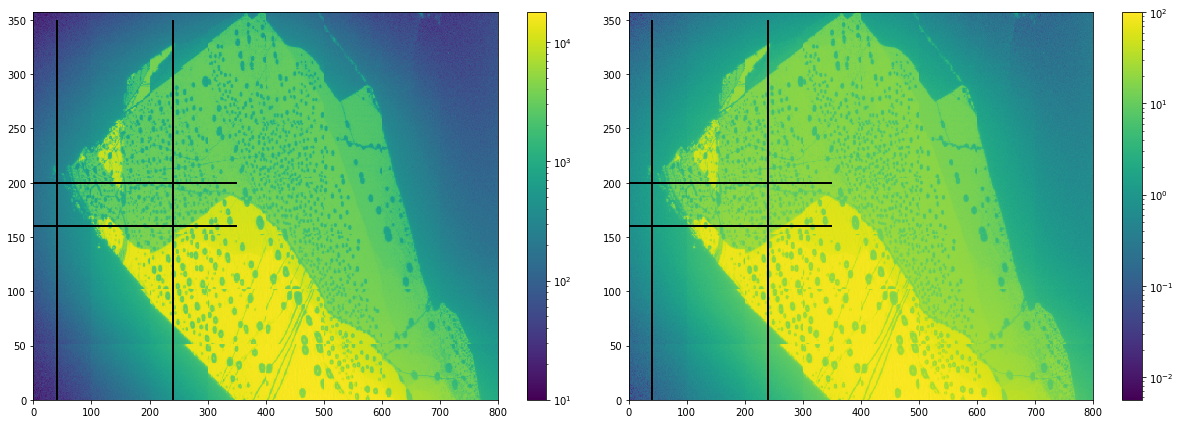

In [129]:
fig, axs = plt.subplots(1, 3, figsize=[17,6])
plt.subplot(1,2,1)
plt.pcolormesh(int1, cmap=cm, norm=cnorm())
plt.vlines([40, 240], ymin=0, ymax=350, color='black', lw=2)
plt.hlines([160, 200], xmin=0, xmax=350, color='black', lw=2)
plt.colorbar()
plt.subplot(1,2,2)
plt.pcolormesh(normalized_int, cmap=cm, norm=cnorm())
plt.vlines([40, 240], ymin=0, ymax=350, color='black', lw=2)
plt.hlines([160, 200], xmin=0, xmax=350, color='black', lw=2)
plt.colorbar()
plt.tight_layout()

In [50]:
cropped = int1[40:240, 160:200].T
normalized_cropped = renormalize(cropped)

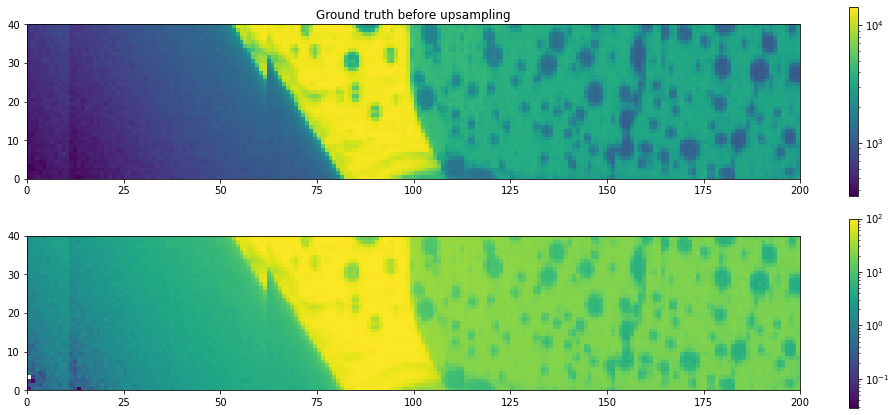

In [121]:
fig, axs = plt.subplots(2, 1, figsize=[14,6])
plt.subplot(2,1,1)
plt.pcolormesh(cropped, cmap=cm, norm=cnorm())
plt.gca().set_aspect('equal')
plt.title('Ground truth before upsampling')
plt.colorbar()
plt.subplot(2,1,2)
plt.pcolormesh(normalized_cropped, cmap=cm, norm=cnorm())
plt.gca().set_aspect('equal')
plt.colorbar()
plt.tight_layout()


In [104]:
cropped_upsamped = np.random.poisson(rescale(cropped, 2))
normalized_cropped_upsamp = renormalize(cropped_upsamped)

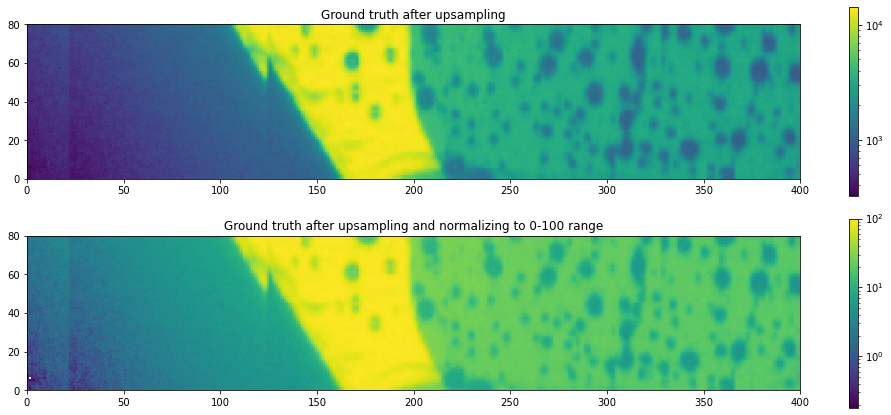

In [130]:
fig, axs = plt.subplots(2, 1, figsize=[14,6])
plt.subplot(2,1,1)
plt.pcolormesh(cropped_upsamped, cmap=cm, norm=cnorm())
plt.gca().set_aspect('equal')
plt.title('Ground truth after upsampling')
plt.colorbar()
plt.subplot(2,1,2)
plt.pcolormesh(normalized_cropped_upsamp, cmap=cm, norm=cnorm())
plt.gca().set_aspect('equal')
plt.colorbar()
plt.title('Ground truth after upsampling and normalizing to 0-100 range')
plt.tight_layout()

In [134]:
inner_batch_size = 100
initial_scan_points_num = 500

stop_ratio = 0.3
store_results_percentage = 1

affected_neighbors_window_min = 5
affected_neighbors_window_max = 15
full_erd_recalculation_frequency = 1

In [135]:
params_erd = ERDInputParams(c_value=C_VALUE,
                            full_erd_recalculation_frequency=full_erd_recalculation_frequency,
                            affected_neighbors_window_min=affected_neighbors_window_min,
                            affected_neighbors_window_max=affected_neighbors_window_max)
params_gen = GeneralInputParams()

sample_params = SampleParams(image_shape=normalized_cropped_upsamp.shape,
                             inner_batch_size=inner_batch_size,
                             initial_scan_points_num=initial_scan_points_num,
                             initial_scan_ratio=None,
                             stop_ratio=stop_ratio,
                             random_seed=11)


#measurement_interface = ExperimentMeasurementInterface()#'instructions.csv', num_initial_idxs= 2000)
#interface.perform_measurement(sample_params.initial_idxs)
measurement_interface = TransmissionSimulationMeasurementInterface(image=normalized_cropped_upsamp)

In [136]:
np.savetxt('instructions_000.csv', sample_params.initial_idxs, delimiter=',', fmt='%10d')

In [108]:
sample = Sample(sample_params=sample_params,
                general_params=params_gen,
                erd_params=params_erd,
                measurement_interface=measurement_interface,
                erd_model=erd_model)
results = Result()

In [109]:
run_sampling(sample, results=results, results_frequency_step=1, results_frequency_percentage=0, 
             disable_progress_bar=False, debug=False, indices_to_actually_measure=50)

Reached the stopping ratio set in the sample parameters. Stopping scan.


(<sladsnet.code.results.Result at 0x15be378e0>, 182)

In [110]:
erds = results.outputs.erds
total_erds = np.sum(erds, axis=(1,2))

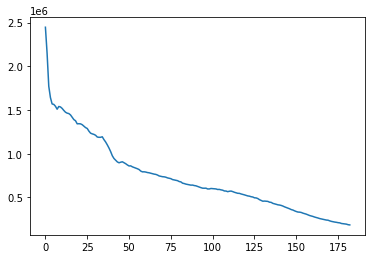

In [111]:
plt.plot(total_erds)

In [112]:
total_erds

array([2446398.8 , 2149028.8 , 1772273.9 , 1642159.4 , 1569151.8 ,
       1564539.5 , 1542981.  , 1509288.5 , 1540477.1 , 1535165.1 ,
       1518445.2 , 1495255.2 , 1474913.2 , 1464279.5 , 1459361.6 ,
       1444086.9 , 1417196.5 , 1390671.6 , 1377413.  , 1342364.  ,
       1343400.2 , 1341874.8 , 1332182.2 , 1314831.5 , 1299180.2 ,
       1288978.5 , 1258749.5 , 1235602.2 , 1227338.6 , 1221457.9 ,
       1211283.8 , 1191428.2 , 1188042.8 , 1188202.  , 1194100.5 ,
       1161622.6 , 1134810.4 , 1101904.8 , 1065795.  , 1024791.1 ,
        977232.1 ,  945647.6 ,  926674.1 ,  906787.25,  896758.9 ,
        903231.5 ,  908243.5 ,  897793.3 ,  886313.5 ,  872249.4 ,
        860658.9 ,  861557.6 ,  850487.2 ,  843139.8 ,  834955.94,
        828610.94,  819554.5 ,  802215.7 ,  793130.1 ,  793644.1 ,
        790734.6 ,  785238.1 ,  782465.3 ,  777390.4 ,  772235.7 ,
        767090.  ,  764088.  ,  756911.25,  746409.2 ,  742011.75,
        737708.7 ,  736117.56,  732013.6 ,  724070.56,  719365

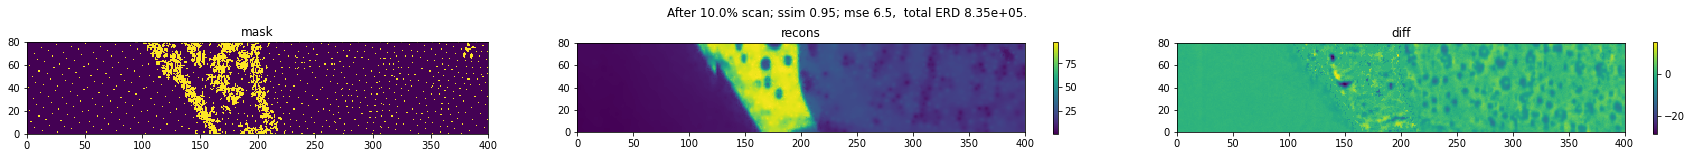

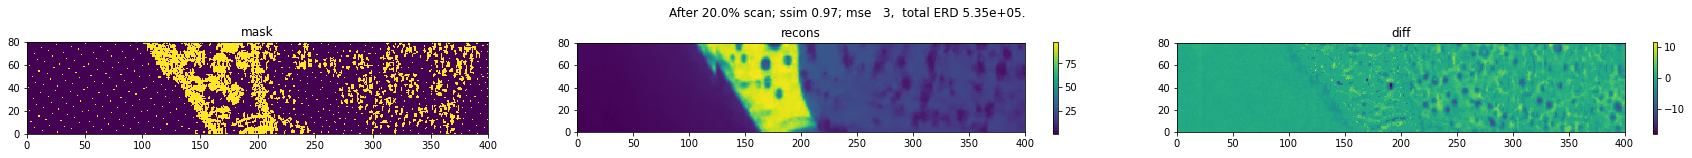

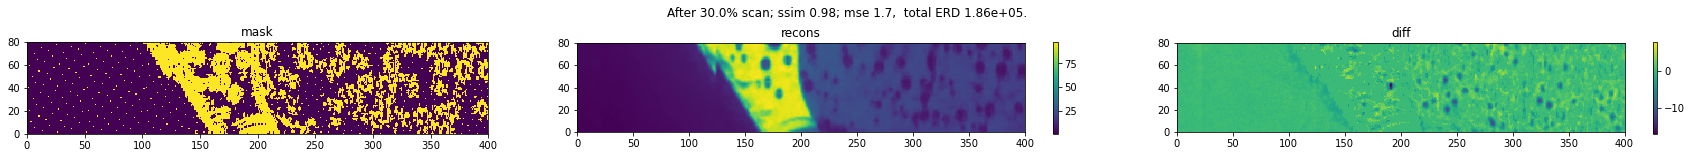

In [113]:
for i in range(results.size):
    #scan_ratio = (i + 1) * 0.1
    #percent = int(scan_ratio * 100)
    
    #if percent >= results.size:
    #    percent = results.size - 1
    
    actual_percent = round(results.outputs.masks[i].sum() / results.outputs.masks[i].size * 100, 2)
    #percent_outside_sample = results.outputs.masks[i][xrf_threshold].sum() / results.outputs.masks[i].size * 100
    percent = actual_percent
    #print(actual_percent)
    if percent not in [8.5, 10, 20, 30]: continue
    
    
    fig, axs = plt.subplots(1, 3, figsize=[25, 2])
    plt.subplot(1, 3, 1)
    plt.pcolormesh(results.outputs.masks[i])
    plt.gca().set_aspect('equal')
    plt.title('mask')
    plt.subplot(1, 3, 2)
    plt.pcolormesh(results.outputs.recons[i], cmap=cm)
    plt.gca().set_aspect('equal')
    plt.colorbar()
    plt.title('recons')
    plt.subplot(1, 3, 3)
    err = measurement_interface.image - results.outputs.recons[i]
    plt.pcolormesh(measurement_interface.image - results.outputs.recons[i])
    plt.gca().set_aspect('equal')
    plt.colorbar()
    plt.title('diff')
    
    ssim = structural_similarity(results.outputs.recons[i], measurement_interface.image, 
                                 data_range=255)
    mse = mean_squared_error(results.outputs.recons[i], measurement_interface.image)
    erd_this = results.outputs.erds[i].sum()
    
    plt.suptitle(f'After {actual_percent}% scan; ssim {ssim:3.2g}; mse {mse:3.2g}, '
                 f' total ERD {erd_this:4.3g}.')
    plt.tight_layout()
    plt.show()


### Running the scan on the log 

In [114]:

log_cropped_upsamp = renormalize(clean_and_normalize(np.log(cropped_upsamped)))

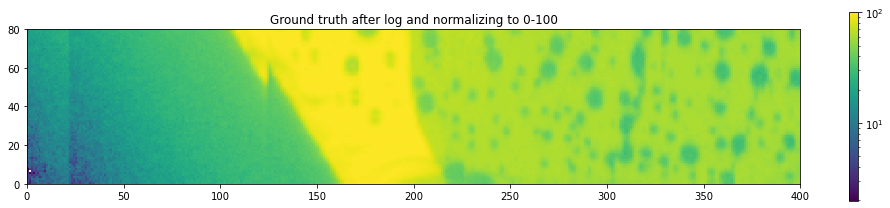

In [124]:
fig, axs = plt.subplots(1, 1, figsize=[14, 3])
plt.subplot(1,1,1)
plt.pcolormesh(log_cropped_upsamp, cmap=cm, norm=cnorm())
plt.gca().set_aspect('equal')
plt.colorbar()
plt.title('Ground truth after log and normalizing to 0-100')
plt.tight_layout()

In [125]:
params_erd = ERDInputParams(c_value=C_VALUE,
                            full_erd_recalculation_frequency=full_erd_recalculation_frequency,
                            affected_neighbors_window_min=affected_neighbors_window_min,
                            affected_neighbors_window_max=affected_neighbors_window_max)
params_gen = GeneralInputParams()

sample_params = SampleParams(image_shape=log_cropped_upsamp.shape,
                             inner_batch_size=inner_batch_size,
                             initial_scan_points_num=initial_scan_points_num,
                             initial_scan_ratio=None,
                             stop_ratio=stop_ratio,
                             random_seed=11)


#measurement_interface = ExperimentMeasurementInterface()#'instructions.csv', num_initial_idxs= 2000)
#interface.perform_measurement(sample_params.initial_idxs)
measurement_interface = TransmissionSimulationMeasurementInterface(image=log_cropped_upsamp)

In [126]:
sample = Sample(sample_params=sample_params,
                general_params=params_gen,
                erd_params=params_erd,
                measurement_interface=measurement_interface,
                erd_model=erd_model)
results = Result()

In [127]:
run_sampling(sample, results=results, results_frequency_step=1, results_frequency_percentage=0, 
             disable_progress_bar=False, debug=False, indices_to_actually_measure=50)

Reached the stopping ratio set in the sample parameters. Stopping scan.


(<sladsnet.code.results.Result at 0x15ba89ea0>, 182)

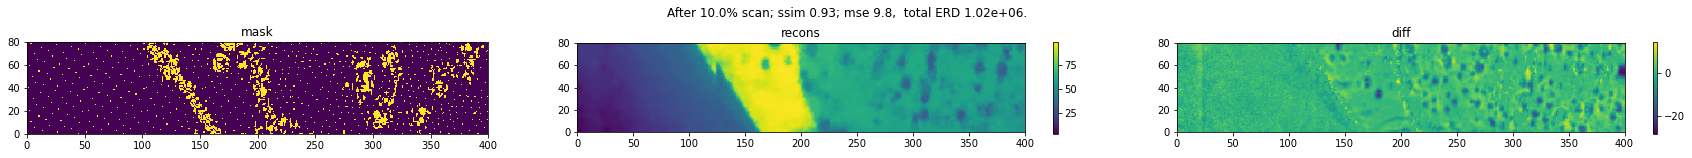

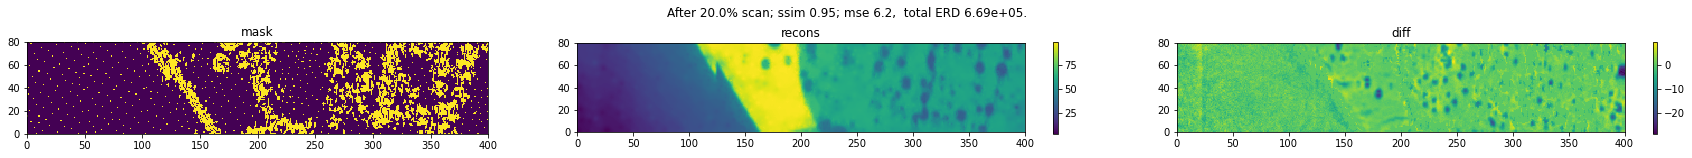

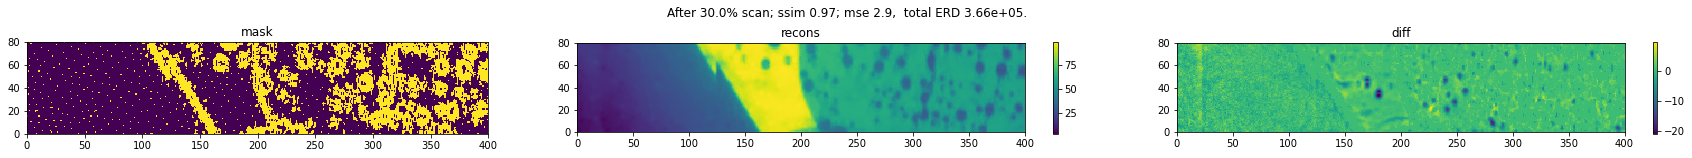

In [128]:
for i in range(results.size):
    #scan_ratio = (i + 1) * 0.1
    #percent = int(scan_ratio * 100)
    
    #if percent >= results.size:
    #    percent = results.size - 1
    
    actual_percent = round(results.outputs.masks[i].sum() / results.outputs.masks[i].size * 100, 2)
    #percent_outside_sample = results.outputs.masks[i][xrf_threshold].sum() / results.outputs.masks[i].size * 100
    percent = actual_percent
    #print(actual_percent)
    if percent not in [8.5, 10, 20, 30]: continue
    
    
    fig, axs = plt.subplots(1, 3, figsize=[25, 2])
    plt.subplot(1, 3, 1)
    plt.pcolormesh(results.outputs.masks[i])
    plt.gca().set_aspect('equal')
    plt.title('mask')
    plt.subplot(1, 3, 2)
    plt.pcolormesh(results.outputs.recons[i], cmap=cm)
    plt.gca().set_aspect('equal')
    plt.colorbar()
    plt.title('recons')
    plt.subplot(1, 3, 3)
    err = measurement_interface.image - results.outputs.recons[i]
    plt.pcolormesh(measurement_interface.image - results.outputs.recons[i])
    plt.gca().set_aspect('equal')
    plt.colorbar()
    plt.title('diff')
    
    ssim = structural_similarity(results.outputs.recons[i], measurement_interface.image, 
                                 data_range=255)
    mse = mean_squared_error(results.outputs.recons[i], measurement_interface.image)
    erd_this = results.outputs.erds[i].sum()
    
    plt.suptitle(f'After {actual_percent}% scan; ssim {ssim:3.2g}; mse {mse:3.2g}, '
                 f' total ERD {erd_this:4.3g}.')
    plt.tight_layout()
    plt.show()


In [131]:
erds = results.outputs.erds
total_erds = np.sum(erds, axis=(1,2))

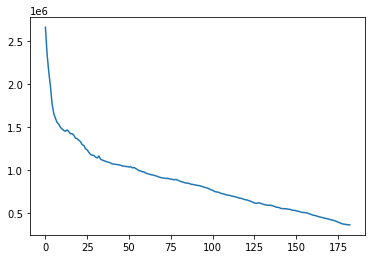

In [132]:
plt.plot(total_erds)

In [133]:
total_erds

array([2659455.5 , 2345256.  , 2143169.  , 1975068.8 , 1768025.  ,
       1656801.2 , 1601453.6 , 1555442.2 , 1533686.  , 1497705.1 ,
       1478066.6 , 1462101.9 , 1452818.5 , 1467753.9 , 1448253.5 ,
       1423522.5 , 1424656.4 , 1406055.8 , 1372695.2 , 1366002.2 ,
       1347471.5 , 1332174.  , 1297443.8 , 1287053.  , 1250261.8 ,
       1236727.8 , 1207681.9 , 1183282.8 , 1175336.5 , 1172098.5 ,
       1153222.1 , 1143299.4 , 1165687.8 , 1127527.6 , 1119421.4 ,
       1110516.8 , 1104910.  , 1097208.  , 1092125.5 , 1085279.2 ,
       1072879.2 , 1073154.1 , 1068228.8 , 1066475.8 , 1063412.2 ,
       1058924.  , 1049411.8 , 1049495.  , 1044422.2 , 1042705.2 ,
       1038353.25, 1042973.4 , 1027207.5 , 1033285.  , 1019778.75,
       1009078.25,  995311.8 ,  992605.  ,  982551.06,  979782.6 ,
        967158.9 ,  961828.6 ,  956220.06,  949231.25,  946880.06,
        940396.4 ,  936124.4 ,  929531.5 ,  920899.3 ,  916550.6 ,
        911240.2 ,  909733.6 ,  905856.7 ,  906558.  ,  901896